In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from model.data_process import *
from model.linear_trading import *
from model.reduction import *
from model.diagnosis import *

from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.cluster import KMeans, OPTICS, SpectralClustering
from sklearn.model_selection import ParameterGrid

import umap
from statsmodels.tsa.stattools import coint
from itertools import combinations
from collections import defaultdict

import os

import statsmodels.api as sm

datapath = "../data/final_processed/"

%matplotlib inline
%load_ext autoreload
%autoreload 2

## 1. Data Preparation

In [138]:
daily = pd.read_csv(datapath + '/daily_prices.csv', parse_dates=['date']).sort_values(['date','ticker']).set_index('date')
ratios = pd.read_csv(datapath + '/firm_ratios.csv', parse_dates=['date']).sort_values(['date','ticker']).set_index('date')
sectors = pd.read_csv(datapath + '/sectors.csv', parse_dates=['date']).sort_values(['date','ticker']).set_index('date')
short = pd.read_csv(datapath + '/short_interest_rate.csv', parse_dates=['date']).sort_values(['date','ticker']).set_index('date')
# Merge
df = daily.merge(ratios, on=['ticker', 'date'], how = 'left')
df = df.merge(short, on =['ticker', 'date'], how = 'left')
df = df.merge(sectors, on=['ticker', 'date'], how = 'left')

tickers = pd.read_csv("../data/sp500_tickers/sp500_historical.csv", parse_dates=['date']).set_index('date')
tickers.shape


/var/folders/1t/_7p_zm4x449blqs7bvqvb0rm0000gn/T/ipykernel_82550/4116403870.py:2: DtypeWarning: Columns (70) have mixed types. Specify dtype option on import or set low_memory=False.
  ratios = pd.read_csv(datapath + '/firm_ratios.csv', parse_dates=['date']).sort_values(['date','ticker']).set_index('date')


(2666, 1)

Use DataPreparation to store data. This will do all the preprocessing based on the saved data.

In [140]:
datagen = DataPrepation(df, tickers)
del tickers, df, daily, ratios, sectors, short

Give index of subset by month (or date).

train_end and test_start should not overlap.

In [10]:
train_start, train_end = '2010-01', '2010-12'
test_start, test_end = '2011-01', '2011-06'

# X_train, idx = datagen.dimension_reduction_preprocess(train_start, train_end)
# price_trade = datagen.trading_preprocess(pairs_list, start, end, test_start, test_end)

## 2. Dimension reduction and clustering

In [7]:
dim_reduction_methods = [
    {'name': 'PCA', 'method': PCA, 'params': {'n_components': [2, 3, 4]}},
    {'name': 'KPCA', 'method': KernelPCA, 'params': {'n_components': [2, 3, 4], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}},
    {'name': 'UMAP', 'method': umap.UMAP, 'params': {'n_components': [2, 3, 4], 'n_neighbors': [5, 10, 15]}}
]

clustering_algorithms = [
    {'name': 'KMeans', 'method': KMeans, 'params': {'n_clusters': [3, 5, 7, 9, 10,], 'n_init': ['auto']}},
    {'name': 'OPTICS', 'method': OPTICS, 'params': {'min_samples': [3, 5, 7]}},
    {'name': 'SpectralClustering', 'method': SpectralClustering, 'params': {'n_clusters': [3, 5, 7, 9, 10,]}}
]

In [36]:
X_train, idx, price_norm = datagen.dimension_reduction_preprocess(train_start, train_end)

(33516, 158)
(33516, 159)


For each dimension reduction method, we will use below code

In [38]:
sample_mod = dim_reduction_methods[0]
reducer = DimensionalityReduction(sample_mod['method'], sample_mod['name'], 
                                  X_train, idx, price_norm)

reduced_generator = reducer.fit_generator(sample_mod['params'])

In [39]:
test_data = next(reduced_generator)

# while reduced_generator:
#     test_data = next(reduced_generator)




Clusterings

In [69]:
sample_cluster = clustering_algorithms[0]

In [88]:
cluster = Clustering(sample_cluster['method'], sample_cluster['name'], test_data)
clustered = cluster.clustering_param_tuning(sample_cluster['params'])

0th cluster: 22
1th cluster: 17
2th cluster: 3
3th cluster: 18
4th cluster: 1
5th cluster: 16
6th cluster: 27
7th cluster: 17
8th cluster: 8
9th cluster: 4


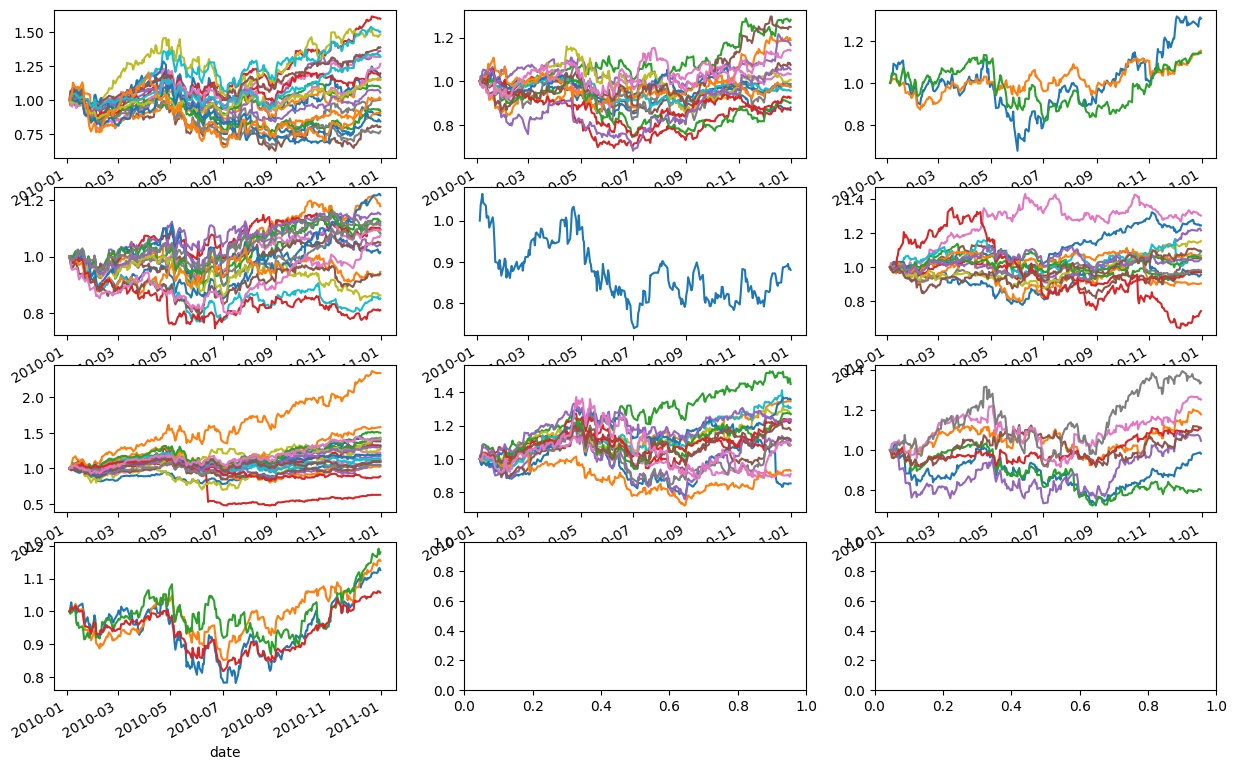

In [167]:
price_norm_df = datagen.price_norm(train_start, train_end)
Diagnosis.plot_clustered(price_norm_df, clustered[-1])

In [253]:
cls = clustered[-1]
price_norm_df = datagen.price_norm(train_start, train_end)
coint_selector = CointegratedSelection(price_norm_df)
pairs_list = coint_selector.select_cointegrated_pairs(cls)

In [254]:
pairs_list

,pair,p-value
0,"(FMC, UNP)",0.000142
1,"(AVY, SNA)",0.000647
2,"(PPG, SEE)",0.001747
3,"(BCR, BDX)",0.001758
4,"(DUK, ED)",0.002351


0th pair: ('FMC', 'UNP')
1th pair: ('AVY', 'SNA')
2th pair: ('PPG', 'SEE')
3th pair: ('BCR', 'BDX')
4th pair: ('DUK', 'ED')


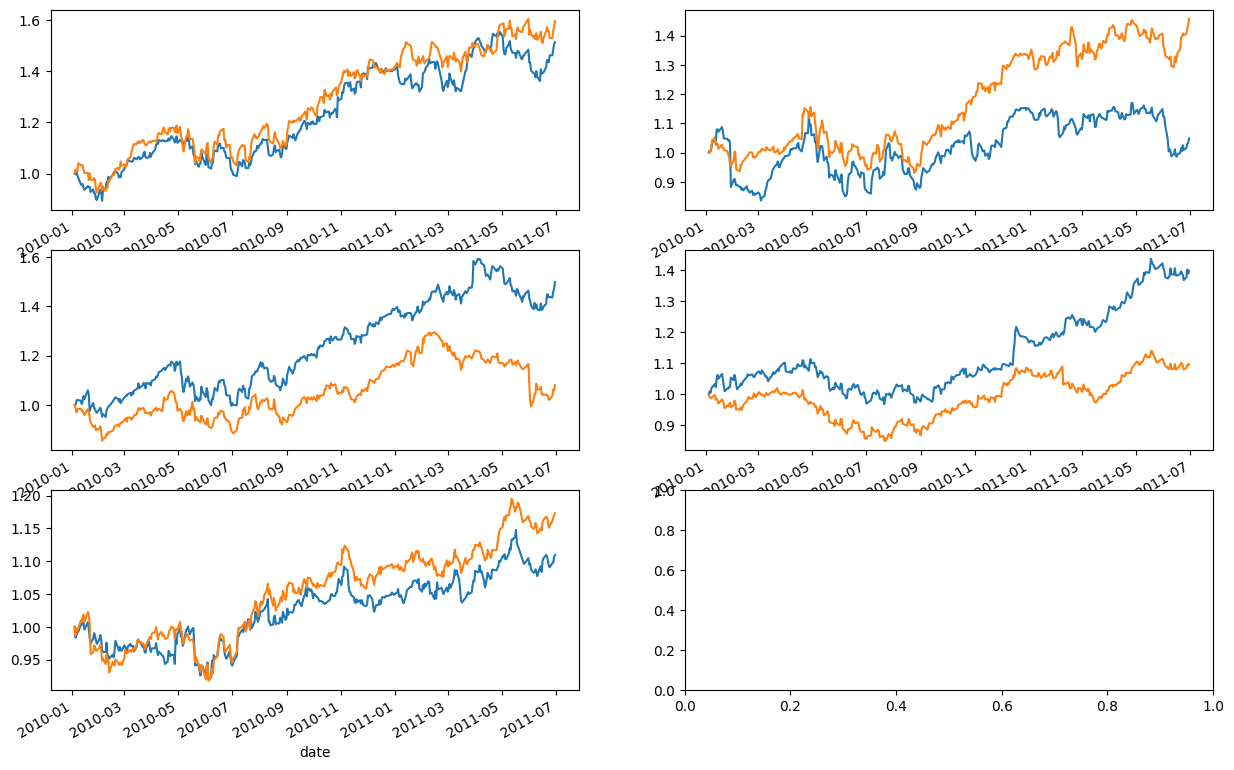

In [169]:
price_norm_df = datagen.price_norm(train_start, test_end)
Diagnosis.plot_test_price(price_norm_df, pairs_list)

## 3. Trading

In [269]:
trade_data = datagen.trading_preprocess(pairs_list.pair.values, train_start, train_end, test_start, test_end)
trade_obj = LinearMulti(trade_data)
trade_obj.get_pnls(list = True)

/Users/hun/miniforge3/envs/hun/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/hun/miniforge3/envs/hun/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/hun/miniforge3/envs/hun/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/de

{('FMC', 'UNP'): 0.047376429560509914,
 ('AVY', 'SNA'): 0.005629956944931402,
 ('PPG', 'SEE'): 0.07743690203732578,
 ('BCR', 'BDX'): -0.039125128210891646,
 ('DUK', 'ED'): 0.009262187244483355}

### 3.1. Check with a sample pair

In [280]:
pairs = list(trade_data.keys())

p = pairs[0]
data = trade_data[p]

trade_example = LinearSignal(p, data)

trade_example.get_pnl()

0.047376429560509914

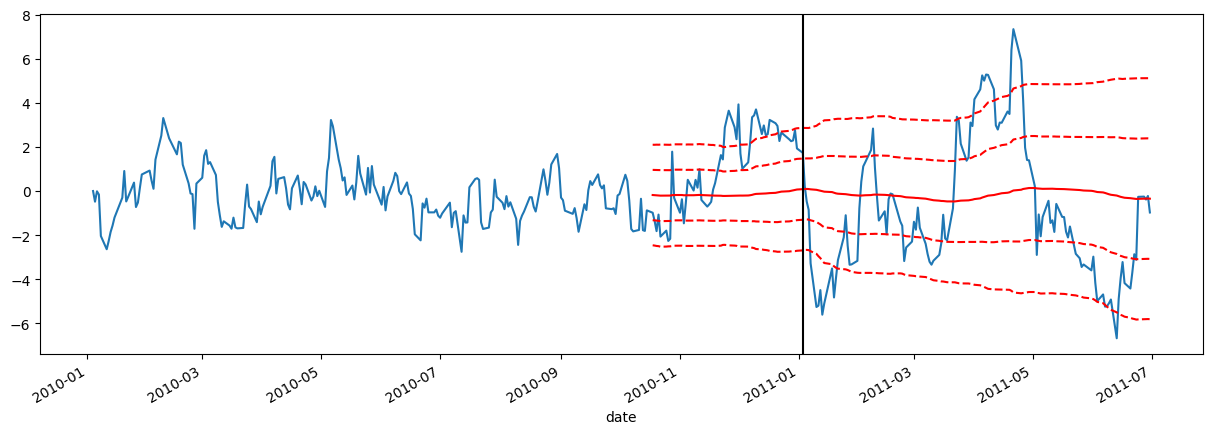

In [281]:
f = trade_example.get_plot()

## 4. Looping

In [2]:
daily = pd.read_csv(datapath + '/daily_prices.csv', parse_dates=['date']).sort_values(['date','ticker']).set_index('date')
ratios = pd.read_csv(datapath + '/firm_ratios.csv', parse_dates=['date']).sort_values(['date','ticker']).set_index('date')
sectors = pd.read_csv(datapath + '/sectors.csv', parse_dates=['date']).sort_values(['date','ticker']).set_index('date')
short = pd.read_csv(datapath + '/short_interest_rate.csv', parse_dates=['date']).sort_values(['date','ticker']).set_index('date')
# Merge
df = daily.merge(ratios, on=['ticker', 'date'], how = 'left')
df = df.merge(short, on =['ticker', 'date'], how = 'left')
df = df.merge(sectors, on=['ticker', 'date'], how = 'left')

tickers = pd.read_csv("../data/sp500_tickers/sp500_historical.csv", parse_dates=['date']).set_index('date')

datagen = DataPrepation(df, tickers)
del tickers, df, daily, ratios, sectors, short

/var/folders/1t/_7p_zm4x449blqs7bvqvb0rm0000gn/T/ipykernel_82640/4073659112.py:2: DtypeWarning: Columns (70) have mixed types. Specify dtype option on import or set low_memory=False.
  ratios = pd.read_csv(datapath + '/firm_ratios.csv', parse_dates=['date']).sort_values(['date','ticker']).set_index('date')


In [3]:
dim_reduction_methods = [
    {'name': 'PCA', 'method': PCA, 'params': {'n_components': [2, 3, 4]}},
    {'name': 'KPCA', 'method': KernelPCA, 'params': {'n_components': [2, 3, 4], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}},
    {'name': 'UMAP', 'method': umap.UMAP, 'params': {'n_components': [2, 3, 4], 'n_neighbors': [5, 10, 15]}}
]

clustering_algorithms = [
    {'name': 'KMeans', 'method': KMeans, 'params': {'n_clusters': [5, 10, 15, 30], 'n_init': ['auto']}},
    {'name': 'OPTICS', 'method': OPTICS, 'params': {'min_samples': [7, 9, 10, 15, 30]}},
    {'name': 'SpectralClustering', 'method': SpectralClustering, 'params': {'n_clusters': [7, 9, 10, 15, 30]}}
]

In [4]:
def save_clusters(start, end):
    X_train, idx, price_norm = datagen.dimension_reduction_preprocess(start, end)
    price_norm_df = datagen.price_norm(start, end)
    
    results = dict()
    for sample_mod in dim_reduction_methods:
        reducer = DimensionalityReduction(sample_mod['method'], sample_mod['name'], 
                                          X_train, idx, price_norm)
        reduced_generator = reducer.fit_generator(sample_mod['params'])
        
        sub_results = dict()
        reduction_number = 0
        while reduced_generator: # reducing methods x hyperparameters
            test_data = next(reduced_generator)
            
            cluster_results = dict()
            for sample_cluster in clustering_algorithms: # clustering methods x hyperparameters :  this is parallelizable
                cluster = Clustering(sample_cluster['method'], sample_cluster['name'], test_data)
                clustered = cluster.clustering_param_tuning(sample_cluster['params']) # list of clustered results by hyperparameters
                
                cluster_result_hyper = dict()
                cluster_number = 0
                for cls in clustered:
                    coint_selector = CointegratedSelection(price_norm_df)
                    pairs_list = coint_selector.select_cointegrated_pairs(cls)
                    
                    cluster_result_hyper[cluster_number] = pairs_list
                    cluster_number += 1
                
                cluster_results[sample_cluster['name']] = cluster_result_hyper
            
            sub_results[reduction_number] = cluster_results
            reduction_number += 1
            
        results[sample_mod['name']] = sub_results
                    
    pkl.dump(results, open(f"../results/{start}-{end}.pkl", "wb"))


In [5]:
def main():
    for year in range(2000, 2010):
        start = f"{year}-01-01"
        end = f"{year}-12-31"
        save_clusters(start, end)

/Users/hun/miniforge3/envs/hun/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/hun/miniforge3/envs/hun/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/hun/miniforge3/envs/hun/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/hun/miniforge3/envs/hun/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/hun/miniforge3/envs/hun/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral emb

{'KMeans': {0:          pair   p-value
  0  (AVY, CSX)  0.000088
  1  (FMC, UNP)  0.000142
  2  (AVY, ROK)  0.000362
  3  (RRD, RTN)  0.000421
  4  (AVY, SNA)  0.000647,
  1:          pair   p-value
  0  (AVY, ROK)  0.000362
  1  (AVY, SNA)  0.000647
  2  (AVY, EMR)  0.000930
  3  (GPC, GWW)  0.000962
  4  (PPG, SEE)  0.001747,
  2:          pair   p-value
  0  (AVY, ROK)  0.000362
  1  (AVY, SNA)  0.000647
  2  (AVY, EMR)  0.000930
  3  (PPG, SEE)  0.001747
  4  (BCR, BDX)  0.001758,
  3:          pair   p-value
  0  (PPG, SEE)  0.001747
  1  (BCR, BDX)  0.001758
  2   (DUK, ED)  0.002351
  3  (EXC, PPL)  0.003831
  4  (APD, EMN)  0.007711},
 'OPTICS': {0:           pair   p-value
  0   (AVY, CSX)  0.000088
  1    (DUK, ED)  0.002351
  2   (AVY, MAR)  0.002835
  3   (EXC, PPL)  0.003831
  4  (KLAC, XRX)  0.004416,
  1:          pair   p-value
  0  (AVY, CSX)  0.000088
  1  (PPG, SEE)  0.001747
  2  (BCR, BDX)  0.001758
  3   (DUK, ED)  0.002351
  4  (AVY, MAR)  0.002835,
  2:         

In [8]:
3.5 * 21 * 20 /60

24.5

In [3]:
os.getcwd()

'/Users/hun/PersonalGit/Uchicago_Programming/ttic-unsupervised/Unsupervised_Final_Project/Notebooks'